### **Deep Learning - Maestría Managment & Analytics**


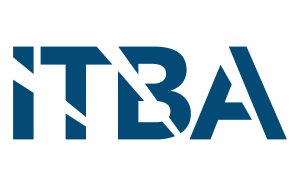

# **Extracción Automatizada de Información en Cartas Documento Bancarias: Comparación de Técnicas OCR y LLM Open Source**


## 1. Problema a Resolver
Este proyecto busca dar los primeros pasos en la creación de un agente que responda cartas documento enviadas a instituciones bancarias. El objetivo es determinar cual es el mejor método de OCR para digitalizar este tipo de documentos. 

## 2. Dataset

* Fuentes públicas **PJN** (pjn.gov.ar).
* CDs en PDF/imágenes, resoluciones variadas (200‑600 dpi).
* Rotación, ruido, sellos y firmas incluidas.


## 3. Herramientas analizadas

| Etapa | Herramienta        | Modelo subyacente                  |
| ----- | ------------------ | ---------------------------------- |
| OCR 1 | **Tesseract 5**    | LSTM bidireccional                 |
| OCR 2 | **Doctr**          | CNN + CTC / Transformer            |
| OCR 3 | **LLM multimodal** | Vision encoder + GPT‑based decoder |

Métrica de evaluación: cadenas de Levenstein

## 4. Indice del repositorio
    1. Presentación
        a. Presentación general del trabajo.
        b. OCR con Pytesseract (archivo readme disponible con requerimientos de sistema)
        c. Extracción de entidades con Ollama
    2. Doctr
        a. Ocr con Doctr (readme disponible con requermientos de sistema)
        b. Extracción de entidades con Ollama
    3. LLM
    4. Conclusión
        a. Análisis de resultados con cadenas de levenstein
        b. Conclusión general


## 5. Entregables
* Dataset de Cartas Documento de ejemplo.
* Notebook para probar Tesseract, Doctr y llm xxx en VS Code – Windows.
* README con requisitos y uso de cada herramienta.
* CSV resumen con variables extraídas de cada PDF.
* Transcripción manual de muestra para evaluación de OCR.
* Informe final con conclusiones y recomendaciones.

# OCR con Tesseract

Tesseract convierte imágenes en texto en cuatro pasos básicos:

- Preprocesado y binarización: Convierte la imagen a blanco y negro con umbrales adaptativos para destacar los trazos de tinta y reducir ruido.

- Segmentación: Encuentra los contornos (“blobs”) de los caracteres, agrupa blobs en líneas y luego en palabras usando análisis de componentes conectados y proyección vertical/horizontal.

- Reconocimiento: Hasta la versión 3 usaba un clasificador basado en patrones y árboles de decisiones. Desde la versión 4 (la que usamos en este análisis) emplea redes LSTM bidireccionales que procesan la secuencia de píxeles línea por línea y generan la probabilidad de cada carácter.

- Post-procesado: Aplica un modelo de lenguaje y diccionarios para corregir errores típicos (p. ej. confundir “0” y “O”), calcular la confianza y producir el texto final.

La documentación de la librería está disponible en https://tesseract-ocr.github.io/tessdoc/tess4/NeuralNetsInTesseract4.00.html?utm_source=chatgpt.com 

## Lectura y extracción de texto
Este script extrae texto de PDFs escaneados usando **PyMuPDF** y utilizando Optical Caracter Recognition de **Tesseract**.  
Antes de correrlo, recomendamos leer los requisitos en readme_ocr-pdf-extractor de este repositorio.

1) Vamos a instalar las librerías necesarias para el proyecto

In [ ]:
#Requisitos previos (solo una vez):
#%pip install pymupdf pillow pytesseract
#   Instalar Tesseract y el idioma español (spa.traineddata) en la computadora (ver instrucciones en el readme)

In [1]:
import os
import io
import fitz  # PyMuPDF
from PIL import Image, ImageDraw
import pytesseract
from pathlib import Path
from pydantic import BaseModel
from typing import Optional

In [ ]:
import csv, json, re, unicodedata
from pathlib import Path
import requests
from requests.exceptions import ReadTimeout
from pydantic import ValidationError
from tqdm import tqdm

2) Definimos una ruta a los archivos. 

Nota: Tenés que ajustarlos según la carpeta donde hayas clonado este repositorio

In [4]:
PDF_FOLDER = r"D:\Formación\Managment & Analytics - ITBA\15. Deep Learning\CDs_Ejemplo\CDs_Ejemplo"            # Carpeta clonada con PDFs
OUTPUT_FOLDER = r"D:\Formación\Managment & Analytics - ITBA\15. Deep Learning\CDs_Ejemplo\Extraccion_Tesseract"      # Carpeta donde se guardarán los .txt


3) Vamos a definir un diccionario con los parámetros del OCR:

- DPI: resolución para renderizar la página (default 300).
- Lang: idioma OCR (español).
- Mode: perfil OCR con LSTM y características específicas para: cuit/dni, nombre y apellido.

In [ ]:
LANG = "spa"     
DPI = 300        # resolución a la que se rasteriza el PDF
PSM = 6          # modo de segmentación de Tesseract (bloque de texto)
#MODE = "texto_general"  # perfil OCR con LSTM y características específicas para: cuit/dni, nombre y apellido

4) Definimos una la función *pdf_to_images* que recorre el pdf y convierte cada página en imagen, extrae el texto  con PyMuPDF y lo guarda. Este paso es importante para después poder aplicar el OCR.  
Luego, definimos la función *ocr_pdf* para procesar los PDFs y guardar el TXT. 

NOta nadia: Ver que use OCR LSTM

In [ ]:
def pdf_to_images(pdf_path: Path, dpi: int):
    doc = fitz.open(pdf_path)
    zoom = dpi / 72
    mat = fitz.Matrix(zoom, zoom)
    for page in doc:
        pix = page.get_pixmap(matrix=mat, alpha=False)
        yield Image.frombytes("RGB", [pix.width, pix.height], pix.samples)


def ocr_pdf(pdf_path: Path) -> str:
    texto = []
    for img in pdf_to_images(pdf_path, DPI):
        texto.append(
            pytesseract.image_to_string(img, lang=LANG, config=f"--psm {PSM}")
        )
    return "\n".join(texto)


5) Ejecutamos el OCR en todos los PDFs de la carpeta y guardamos el texto extraído en archivos .txt

In [ ]:
def main():
    in_dir = Path(PDF_FOLDER)
    out_dir = Path(OUTPUT_FOLDER)
    out_dir.mkdir(parents=True, exist_ok=True)

    pdfs = list(in_dir.glob("*.pdf"))
    if not pdfs:
        print(f"No se encontraron PDFs en {in_dir.resolve()}")
        return

    for pdf in pdfs:
        print(f"Procesando {pdf.name}…")
        texto = ocr_pdf(pdf)
        (out_dir / f"{pdf.stem}.txt").write_text(texto, encoding="utf-8")
    print("Listo. Archivos guardados en", out_dir.resolve())


if __name__ == "__main__":
    main()


## Extracción de variables con Ollama
Vamos a utilizar structured outputs para extraer información de los txt y transformarlos en variables. Esto nos permitirá luego evaluar la calidad del OCR.

In [ ]:
TXT_FOLDER = r"D:\Formación\Managment & Analytics - ITBA\15. Deep Learning\CDs_Ejemplo\Extraccion_Tesseract"
OUTPUT_CSV = "entidades_extraidas_Tesseract.csv"
PROMPT_FILE = "prompt_2.txt"
MODEL       = "llama3:latest"
OLLAMA_URL  = "http://localhost:11434/api/generate"
TEMPERATURE = 0.0
TIMEOUT     = 800
MAX_CHARS   = 9000

In [4]:
class Entity(BaseModel):
    Remitente: Optional[str] = None
    DNI: Optional[str] = None
    CUIT_CUIL: Optional[str] = None
    Cuerpo: str


Vamos a generar una función para eliminar caracteres especiales y saltos de línea del texto extraído

In [6]:
CLEAN_RE = re.compile(r"[^\w\s.,;:()@€$%/-]")

def clean_text(s: str) -> str:
    s = unicodedata.normalize("NFKC", s)
    s = CLEAN_RE.sub("", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip()

Definimos una función para extraer entidades con llama

In [7]:
JSON_SCHEMA = {
    "type": "object",
    "properties": {
        "Remitente": {"type": ["string", "null"]},
        "DNI": {"type": ["string", "null"], "pattern": "^\\d*$"},
        "CUIT_CUIL": {"type": ["string", "null"], "pattern": "^\\d*$"},
        "Cuerpo": {"type": "string"},
    },
    "required": ["Cuerpo"],
    "additionalProperties": False,
}

with open(PROMPT_FILE, encoding="utf-8") as f:
    PROMPT = f.read()

def call_ollama(text: str) -> dict:
    payload = {
        "model": MODEL,
        "prompt": f"<|system|>\n{PROMPT}<|end|>\n<|user|>\n{text[:MAX_CHARS]}<|end|>\n<|assistant|>",
        "format": "json",
        "stream": False,
        "options": {"temperature": TEMPERATURE, "json_schema": JSON_SCHEMA},
    }
    try:
        r = requests.post(OLLAMA_URL, json=payload, timeout=TIMEOUT)
    except ReadTimeout:
        raise TimeoutError("Timeout de Ollama")
    r.raise_for_status()
    return json.loads(r.json()["response"])

def main():
    dir_path = Path(TXT_FOLDER)
    if not dir_path.is_dir():
        raise SystemExit(f"Ruta no encontrada: {dir_path}")

    rows = []
    for file in tqdm(sorted(dir_path.glob("*.txt")), desc="TXT"):
        raw = file.read_text(encoding="utf-8", errors="ignore")
        cleaned = clean_text(raw)
        try:
            data = call_ollama(cleaned)
            ent = Entity.model_validate(data)
            rows.append({
                "ARCHIVO": file.name,
                "Remitente": (ent.Remitente or "NaN").strip() or "NaN",
                "DNI": re.sub(r"\D", "", ent.DNI or "") or "NaN",
                "CUIT_CUIL": re.sub(r"\D", "", ent.CUIT_CUIL or "") or "NaN",
                "Cuerpo": ent.Cuerpo.strip() or "NaN",
            })
        except Exception as e:
            print(f"❌ {file.name}: {e}")
    if rows:
        with open(OUTPUT_CSV, "w", newline="", encoding="utf-8") as f:
            csv.DictWriter(f, fieldnames=rows[0].keys()).writeheader(); csv.DictWriter(f, fieldnames=rows[0].keys()).writerows(rows)
        print(f"✅ CSV generado en {OUTPUT_CSV} ({len(rows)} filas)")
    else:
        print("No se extrajeron entidades válidas.")

Ejecutamos

In [8]:
if __name__ == "__main__":
    main()

TXT:  67%|██████▋   | 8/12 [55:28<32:11, 482.88s/it]

❌ hsbc_Aquino2.txt: Timeout de Ollama


TXT: 100%|██████████| 12/12 [1:18:49<00:00, 394.12s/it]


✅ CSV generado en entidades_extraidas_ollama.csv (11 filas)
